### Implementation of Bengio et al 2013

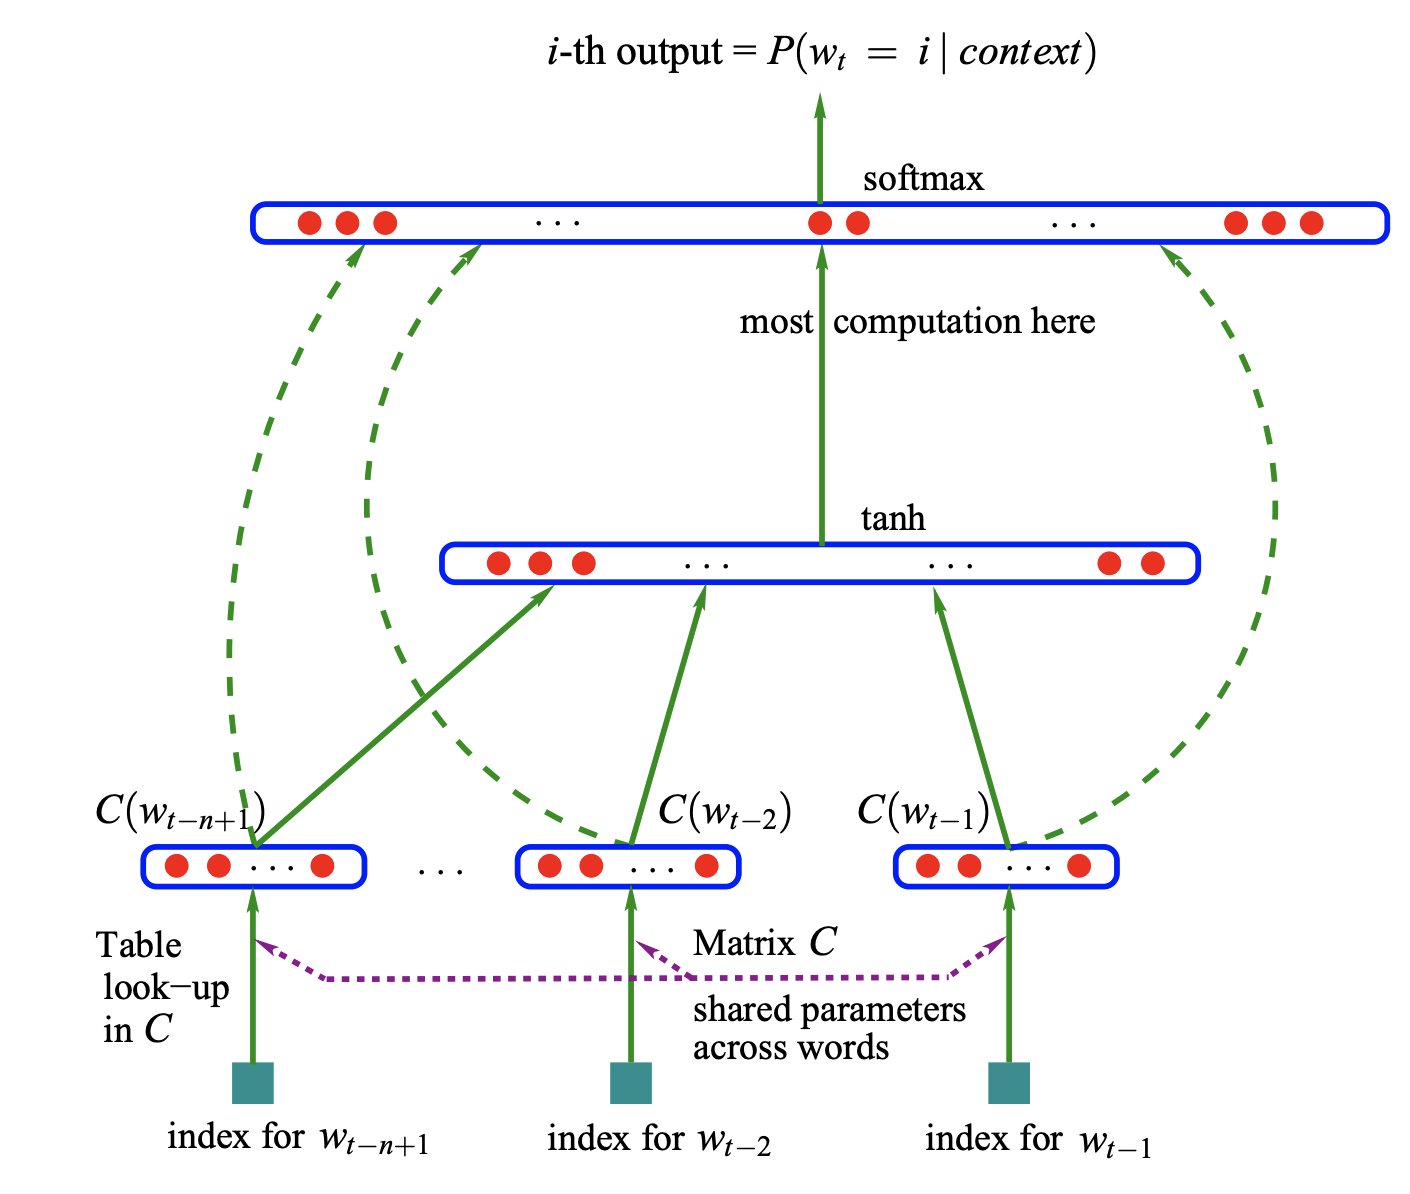

In [147]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

Vocab of chars and mapping to integers

In [9]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [10]:
block_size = 3 #context length
X, Y = [], []

for w in words[:5]:

    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] #crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)     

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [13]:
X.shape, Y.shape, X.dtype, Y.dtype

(torch.Size([32, 3]), torch.Size([32]), torch.int64, torch.int64)

Embedding lookup table

- Create 2 dimensional embeddings

In [14]:
C = torch.randn([27, 2])

Picking out 5th row

In [18]:
C[5]

tensor([-0.8602, -1.6399])

Picking out 5th row with one hot and matmul

In [17]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.8602, -1.6399])

Index with a tensor

- Embedding for each 32,3 context vector

In [21]:
C[X].shape

torch.Size([32, 3, 2])

In [22]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

Hidden Layer

In [24]:
W1 = torch.randn([3*2, 100]) #3 inputs of 2 dim and 100 neurons, 100 is a hyperparam
b1 = torch.randn(100)

Concat the embeddings

In [25]:
emb[:, 0, :].shape

torch.Size([32, 2])

In [27]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([32, 6])

In [28]:
a = torch.arange(18)

In [30]:
a.view(2, 3, 3) #extremely efficient, no new memory is created

tensor([[[ 0,  1,  2],
         [ 3,  4,  5],
         [ 6,  7,  8]],

        [[ 9, 10, 11],
         [12, 13, 14],
         [15, 16, 17]]])

In [34]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # -1 infers the dim size and view concats 32,3,2 to 32,6
# same 100 dim bias vector is added

In [35]:
h.shape

torch.Size([32, 100])

Last layer - Softmax

In [36]:
W2 = torch.randn([100, 27])
b2 = torch.randn(27)

In [38]:
logits = h @ W2 + b2

In [39]:
logits.shape

torch.Size([32, 27])

In [40]:
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
probs.shape

torch.Size([32, 27])

In [41]:
probs[0].sum()

tensor(1.)

Prob of correct char

In [42]:
probs[torch.arange(32), Y]

tensor([4.5954e-01, 1.5110e-07, 3.7821e-12, 1.5683e-10, 5.9010e-09, 6.7880e-05,
        1.2303e-06, 1.0642e-05, 7.6312e-10, 9.7865e-06, 2.5599e-05, 1.2694e-09,
        5.1315e-08, 3.0703e-11, 3.4364e-06, 8.9699e-05, 5.2786e-14, 2.8798e-03,
        6.7810e-17, 4.4885e-10, 4.1789e-09, 2.8943e-08, 3.0500e-07, 1.0151e-12,
        5.1656e-10, 1.4137e-08, 8.7497e-05, 8.3323e-09, 1.1765e-06, 1.6364e-07,
        9.6648e-09, 2.1812e-11])

Loss

In [44]:
loss = -probs[torch.arange(32), Y].log().mean()
loss

tensor(17.4868)

Combine all layers

Dataset

In [45]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

Parameters

In [47]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g) #Embeddings
W1 = torch.randn((6, 100), generator=g) #Hidden layer
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)#Softmax layer
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [48]:
sum(p.nelement() for p in parameters) # total no of params

3481

Layers

Forward pass

In [56]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #32, 100
logits = h @ W2 +b2 #32, 27
# counts = logits.exp()
# probs = counts / counts.sum(1, keepdim=True)
# loss = -probs[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Y) # much better impl in pytorch, avoid issue with large values, memeory efficient
loss

tensor(17.7697, grad_fn=<NllLossBackward0>)

Backward pass

In [57]:
for p in parameters:
    p.requires_grad=True

In [58]:
for p in parameters:
    p.grad = None
loss.backward()

#update
for p in parameters:
    p.data += -0.1 * p.grad

Full training loop

In [62]:
for _ in range(500):
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #32, 100
    logits = h @ W2 +b2 #32, 27
    loss = F.cross_entropy(logits, Y)
    
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())

0.25577861070632935


Full dataset

In [66]:

block_size = 3 #context length
X, Y = [], []

for w in words:

    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] #crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)     

In [67]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [68]:
for _ in range(50):
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #32, 100
    logits = h @ W2 +b2 #32, 27
    loss = F.cross_entropy(logits, Y)
    
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())

5.377645969390869


This runs every epoch of forward and backward pass on all the data points, which is slow

We can instead run this on minibatches: randomly selected data points

- In every epoch, model will see a minibatch of data instead of all data
- A type of stochastic grad descent
- Model will converge faster
- Loss might not reduce as much as with all data points

In [70]:
torch.randint(0, X.shape[0], (32, ))

tensor([ 45089, 217483,  14496, 177546, 188578, 132398,  95875, 212273, 148910,
         79685,  76254, 111378, 109831,  45196, 169730,  31318, 170813,  25989,
         76192, 143529, 124868, 176531,  84594, 223912, 196837, 161717,  36819,
        210437, 192014,  40336,  19550,  57150])

In [96]:
for _ in range(1000): #epochs

    #minibatch
    ix = torch.randint(0, X.shape[0], [32, ]) #minibatch size is 32 and ix is gen between 0 and len(words)
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #32, 100
    logits = h @ W2 +b2 #32, 27
    loss = F.cross_entropy(logits, Y[ix])
    
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())

2.306633472442627


In [97]:
emb = C[X] #(32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #32, 100
logits = h @ W2 +b2 #32, 27
loss = F.cross_entropy(logits, Y)
loss

tensor(2.4594, grad_fn=<NllLossBackward0>)

Optimise the learning rate

In [123]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g) #Embeddings
W1 = torch.randn((6, 100), generator=g) #Hidden layer
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)#Softmax layer
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [124]:
for p in parameters:
    p.requires_grad=True

Search the learning rate in exponentiated scale

In [116]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [120]:
lri = []
lossi = []

for i in range(1000): #epochs

    #minibatch
    ix = torch.randint(0, X.shape[0], [32, ]) #minibatch size is 32 and ix is gen between 0 and len(words)
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #32, 100
    logits = h @ W2 +b2 #32, 27
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())
    
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    for p in parameters:
        p.data += - lrs[i] * p.grad

    #track stats
    lri.append(lre[i])
    lossi.append(loss.item())
# print(loss.item())

5.979501247406006
6.780250549316406
5.628541946411133
6.236208915710449
5.953721046447754
6.086234092712402
6.146888732910156
5.3443803787231445
5.580915451049805
6.489588737487793
6.090851783752441
6.841320037841797
6.368745803833008
5.866542339324951
5.765898704528809
5.857174396514893
6.885862827301025
5.350732326507568
5.775218486785889
4.642845153808594
6.1144866943359375
5.117713451385498
5.397027969360352
5.034573554992676
5.77876615524292
4.7324724197387695
4.540618419647217
5.208573341369629
5.988941192626953
5.5150146484375
5.497392654418945
4.9175825119018555
4.742561340332031
5.211848258972168
5.661703586578369
6.430318355560303
5.069711685180664
6.387731075286865
6.422171115875244
6.283777713775635
4.267730236053467
5.478771686553955
4.434667587280273
5.277799606323242
5.187305927276611
5.3337788581848145
5.680775165557861
5.160742282867432
5.135210990905762
5.605146884918213
5.552602291107178
6.1302056312561035
6.685054779052734
4.39633846282959
6.135367393493652
6.110582

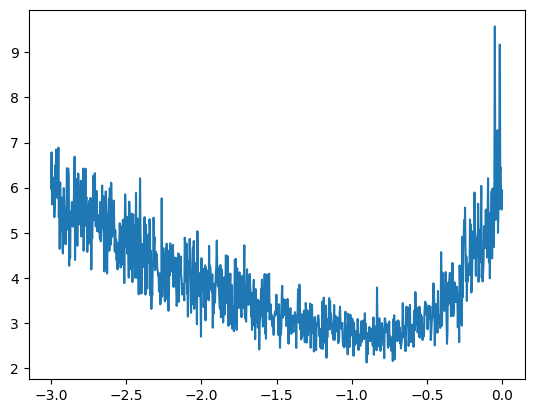

In [121]:
plt.plot(lri, lossi)

0.1 is a good learning rate here

In [125]:

for i in range(100000): #epochs

    #minibatch
    ix = torch.randint(0, X.shape[0], [32, ]) #minibatch size is 32 and ix is gen between 0 and len(words)
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #32, 100
    logits = h @ W2 +b2 #32, 27
    loss = F.cross_entropy(logits, Y[ix])
    
    
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    for p in parameters:
        p.data += - 0.1 * p.grad

print(loss.item())

2.224656581878662


In [127]:
emb = C[X] #(32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #32, 100
logits = h @ W2 +b2 #32, 27
loss = F.cross_entropy(logits, Y)
loss

tensor(2.2578, grad_fn=<NllLossBackward0>)

At the end decay the learning rate

In [145]:

for i in range(1000): #epochs

    #minibatch
    ix = torch.randint(0, X.shape[0], [32, ]) #minibatch size is 32 and ix is gen between 0 and len(words)
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #32, 100
    logits = h @ W2 +b2 #32, 27
    loss = F.cross_entropy(logits, Y[ix])
    
    
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    for p in parameters:
        p.data += - 0.01 * p.grad

print(loss.item())

2.1553537845611572


In [146]:
emb = C[X] #(32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #32, 100
logits = h @ W2 +b2 #32, 27
loss = F.cross_entropy(logits, Y)
loss

tensor(2.2515, grad_fn=<NllLossBackward0>)

Build test, dev and test dataset

In [148]:
def build_dataset(words):


    block_size = 3 #context length
    X, Y = [], []

    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] #crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, y_test = build_dataset(words[n2:])

In [149]:
X_train.shape, X_dev.shape, X_test.shape

(torch.Size([182625, 3]), torch.Size([22655, 3]), torch.Size([22866, 3]))

Train on train dataset

In [158]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g) #Embeddings
W1 = torch.randn((6, 300), generator=g) #Hidden layer
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)#Softmax layer
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [159]:
for p in parameters:
    p.requires_grad=True

In [168]:
lri = []
lossi = []
stepi = []
for i in range(30000): #epochs

    #minibatch
    ix = torch.randint(0, X_train.shape[0], [32, ]) #minibatch size is 32 and ix is gen between 0 and len(words)
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #32, 100
    logits = h @ W2 +b2 #32, 27
    loss = F.cross_entropy(logits, Y_train[ix])
    
    
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    for p in parameters:
        p.data += - 0.05 * p.grad

        #track stats
    # lri.append(lre[i])
    lossi.append(loss.item())
    stepi.append(i)

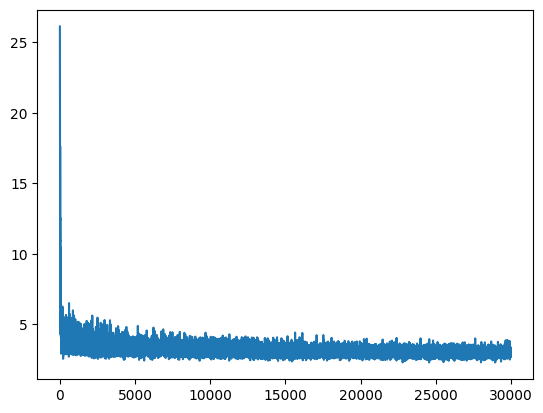

In [161]:
plt.plot(stepi, lossi)

Dev loss

In [169]:
emb = C[X_dev] #(32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #32, 100
logits = h @ W2 +b2 #32, 27
loss = F.cross_entropy(logits, Y_dev)
loss

tensor(2.8888, grad_fn=<NllLossBackward0>)

Training loss

In [170]:
emb = C[X_train] #(32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #32, 100
logits = h @ W2 +b2 #32, 27
loss = F.cross_entropy(logits, Y_train)
loss

tensor(2.8945, grad_fn=<NllLossBackward0>)

Compare train and dev loss to see if model is overfit or underfit
- If train loss and dev loss are similar, model is underfit, scale up the NN

Visualize embeddings

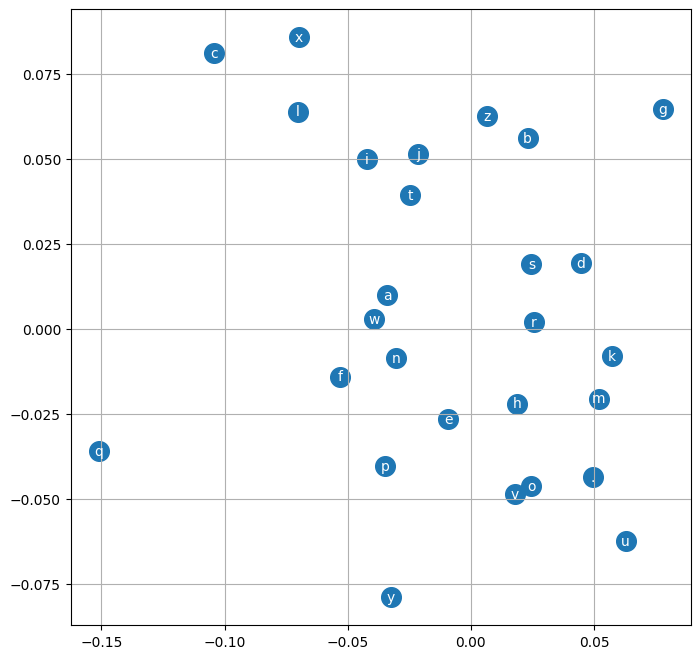

In [171]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

Scale up embeddings

In [179]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g) #Embeddings
W1 = torch.randn((3*10, 200), generator=g) #Hidden layer
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)#Softmax layer
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [180]:
for p in parameters:
    p.requires_grad=True

In [181]:
lri = []
lossi = []
stepi = []

In [197]:

for i in range(50000): #epochs

    #minibatch
    ix = torch.randint(0, X_train.shape[0], [32, ]) #minibatch size is 32 and ix is gen between 0 and len(words)
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 3*10) @ W1 + b1) #32, 200
    logits = h @ W2 +b2 #32, 27
    loss = F.cross_entropy(logits, Y_train[ix])
    
    
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    for p in parameters:
        p.data += - 0.1 * p.grad

        #track stats
    # lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(i)

Plt log loss

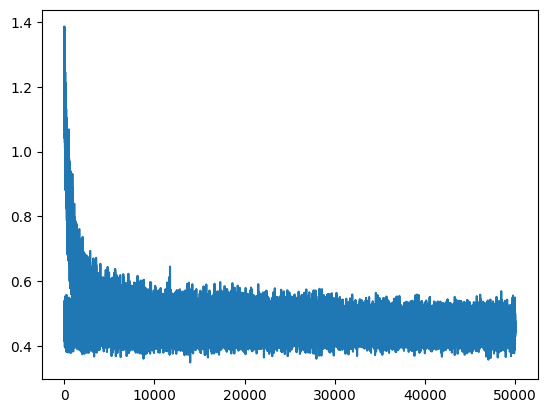

In [ ]:
plt.plot(stepi, lossi)

Dev loss

In [ ]:
emb = C[X_dev] #(32, 3, 2)
h = torch.tanh(emb.view(-1, 3*10) @ W1 + b1) #32, 100
logits = h @ W2 +b2 #32, 27
loss = F.cross_entropy(logits, Y_dev)
loss

tensor(2.8465, grad_fn=<NllLossBackward0>)

Training loss

In [ ]:
emb = C[X_train] #(32, 3, 2)
h = torch.tanh(emb.view(-1, 3*10) @ W1 + b1) #32, 100
logits = h @ W2 +b2 #32, 27
loss = F.cross_entropy(logits, Y_train)
loss

tensor(2.8498, grad_fn=<NllLossBackward0>)